<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tải thư viện pyvi và spcy để tách từ tiếng Việt.

In [1]:
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.6 MB/s eta 0:00:00
  Created wheel for vi-core-news-lg: filename=vi_core_news_lg-3.6.0-py3-none-any.whl size=233275662 sha256=4f9108c1aaa5f4d70c234595be5fbd3d97577ef2fa4626e10bfa19474d008657
  Stored in directory: /root/.cache/pip/wheels/bd/c2/22/8dfcbf9006c1be9c5f38dda2e8608eddb2f46c933f174c7581
Successfully built vi-core-news-lg
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.3
    Uninstalling thinc-8.2.3:
      Successfully uninstalled thinc-8.2.3
  Attempting un

Clone github chứa các module cần thiết đã xây dựng dưới local.

In [2]:
!rm -rf Vietnamese-Review-Classification
!git clone https://github.com/Akechi1412/Vietnamese-Review-Classification
%cd Vietnamese-Review-Classification
!rm -f ./models/review_model.h5

Cloning into 'Vietnamese-Review-Classification'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 136 (delta 32), reused 29 (delta 28), pack-reused 96
Receiving objects: 100% (136/136), 30.24 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/Vietnamese-Review-Classification


Load dữ liệu đánh giá của người dùng đã thu thập được.

Preparing data...
Data size: 9000
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


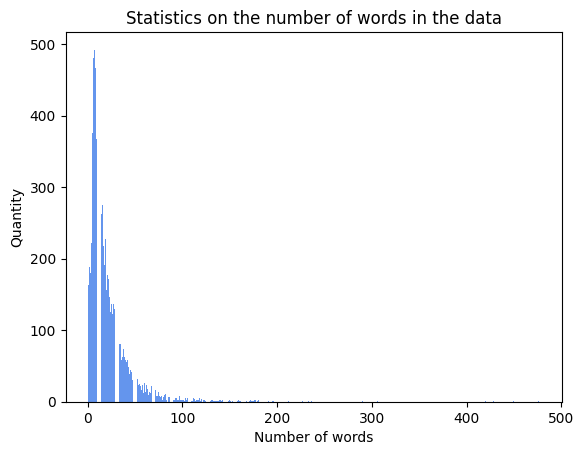

In [3]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data

x_data, y_data = prepare_data()

print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)

Nhận xét: Ta thấy số lượng từ của đánh giá người dùng phần lớp là từ 200 từ trở xuống, tập trung nhiều nhất là dưới 100 từ, vì vậy tiếp theo ta cần giới hạn số lượng từ cần xử lý tối đa là 200 từ để đảm bảo các danh sách từ của mỗi đánh giá là bằng nhau.

Tách dữ liệu đã thu thập được thành 3 phần: tập train, tập validation và tập test theo tỉ lệ 4:1:1.

In [4]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=1/3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

6000 6000
1500 1500
1500 1500


Chuyển đổi danh sách các từ thành các chuỗi số.

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pickle

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Save tokenize
with open('./models/review_tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Pad sequences to ensure uniform length
max_len = 200
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

print(f'({len(x_train_pad)}, {len(x_train_pad[0])})')
print(f'({len(x_val_pad)}, {len(x_val_pad[0])})')
print(f'({len(x_test_pad)}, {len(x_test_pad[0])})')

# Create one hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

(6000, 200)
(1500, 200)
(1500, 200)


Chuyển dữ liệu sang dạng numpy array.

In [7]:
import numpy as np

x_train_pad = np.array(x_train_pad)
x_val_pad = np.array(x_val_pad)
x_test_pad = np.array(x_test_pad)

y_train_one_hot = np.array(y_train_one_hot)
y_val_one_hot = np.array(y_val_one_hot)
y_test_one_hot = np.array(y_test_one_hot)

Xây dựng và huấn luyện mô hình.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import regularizers

# Build RNN model
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.L2(1e-6)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.L2(1e-6)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.L2(1e-6)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.L2(1e-6)))
model.add(Dropout(rate=0.2))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train and save the model,
filepath = './models/review_model.h5'
checkpoint = ModelCheckpoint(
  filepath,
  monitor='val_loss',
  verbose=1,
  save_best_only=True,
  mode='min'
)
callbacks_list = [checkpoint]
history = model.fit(
  x_train_pad, y_train_one_hot,
  batch_size=40,
  epochs=10,
  validation_data=(x_val_pad, y_val_one_hot),
  callbacks=callbacks_list
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          978816    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 128)          0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 128)           0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.8152
Epoch 2: val_loss improved from 0.58731 to 0.55322, saving model to ./models/review_model.h5
150/150 [==============================] - 131s 873ms/step - loss: 0.5537 - accuracy: 0.8152 - val_loss: 0.5532 - val_accuracy: 0.8100
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8427
Epoch 3: val_loss improved from 0.55322 to 0.51102, saving model to ./models/review_model.h5
150/150 [==============================] - 128s 856ms/step - loss: 0.4233 - accuracy: 0.8427 - val_loss: 0.5110 - val_accuracy: 0.8180
Epoch 4/10
150/150 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8868
Epoch 4: val_loss did not improve from 0.51102
150/150 [==============================] - 130s 866ms/step - loss: 0.3241 - accuracy: 0.8868 - val_loss: 0.5614 - val_accuracy: 0.7900
Epoch 5/10
150/150 [==============================] - ETA: 0s - loss: 0.2611 - accura

Vẽ lại đồ thị giá trị mất mát và độ chính xác của tập train và tập validation trong quá trình huấn luyện.

In [ ]:
from utils.plotter import plot_history_model

plot_history_model(history)

Kiểm tra lại mô hình trên tập test.

In [ ]:
from sklearn.metrics import confusion_matrix

score, acc = model.evaluate(x_test_pad, y_test_one_hot, batch_size=15, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

y_pred = model.predict(x_test_pad, batch_size=15)
y_test_single = np.argmax(y_test_one_hot, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_pred_single)
print("Confusion Matrix:")
print(conf_matrix)

Nhận xét: accuracy của tập test sau khi áp dụng mô hình đã huấn luyện là không quá tệ, tuy nhiên nhìn cột thứ 3 của confusion matrix ta thấy các đánh giá trung tính có độ chính xác không cao, rất dễ dự đoán sai sang tích cực hoặc tiêu cực. Điều này xảy ra là do dữ liệu huấn luyện chưa đủ lớn, số lượng nhãn trung tính trong dữ liệu tương đối ít so với hai nhãn còn lại và sự khó khăn trong việc phân biệt giữa cảm xúc của một đánh giá phức tạp dẫn đến gắn nhãn sai.